<a href="https://colab.research.google.com/github/MDYLL/Megafon_test/blob/master/Megafon_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [106]:
df=pd.read_csv('C:/Users/User/Megafon/02_Data.csv',sep=';')

In [107]:
df.head()

lac    cid        msisdn          imei  event_type         tstamp  \
0  5029  40798  158529599791  3.531111e+14           0  1369252800974   
1  7782  56870  158520145943  1.292900e+13           5  1369252801396   
2  7794  32226  158521798391  3.519940e+14           5  1369252802013   
3  7758  33528  158537830573  3.586270e+14           0  1369252802331   
4  5060  17568  158510204039  3.524581e+14           8  1369252803586   

      long      lat  max_dist cell_type  start_angle  end_angle  
0  37.9305  55.7815      2101   OUTDOOR        220.0      280.0  
1  37.4239  55.7426         2   OUTDOOR         45.0      105.0  
2  37.7034  55.5803      1125   OUTDOOR          0.0       60.0  
3  37.7895  55.7042      1158   OUTDOOR        210.0      270.0  
4  37.1900  55.8308       500   OUTDOOR        180.0      240.0

In [108]:
df.shape[0]

174123

## посмотрим период, за который получены данные

In [109]:
pd.to_datetime(df.tstamp.min(), unit='ms'),pd.to_datetime(df.tstamp.max(), unit='ms')

(Timestamp('2013-05-22 20:00:00.974000'),
 Timestamp('2013-05-30 16:29:37.643000'))

## рассмотрим гипотезу - Персона с двумя симками должен регистрироваться в близкие временные интервалы в находящихся рядом вышках. для определения вышек достаточно их географических координат. все остальное выкидываем


In [110]:
df=df.drop(['lac','cid','imei','event_type','max_dist','cell_type','start_angle','end_angle'],axis=1)

## слегка отнормируем время

In [111]:
df.tstamp//=1000
df.tstamp-=df.tstamp.min(axis=0)

## посмотрим распределение регистраций по всему периоду данных

In [125]:
period=df.tstamp.max(axis=0)//1000
y=[]
for i in range(1000):
  y.append(df.loc[(df.tstamp>i*period)&(df.tstamp<=(i+1)*period)].shape[0])

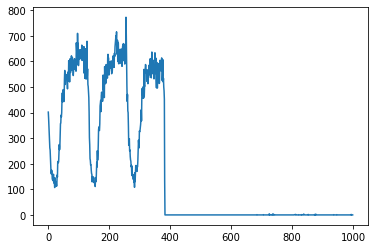

In [126]:
from matplotlib import pyplot as plt
plt.plot(y)
plt.show()

## судя по графику, достаточно будет рассмотреть данные только за первые 40% времени.

In [132]:
df=df.loc[df.tstamp<df.tstamp.max()*0.40]

In [133]:
period=df.tstamp.max(axis=0)//1000
y=[]
for i in range(1000):
  y.append(df.loc[(df.tstamp>i*period)&(df.tstamp<=(i+1)*period)].shape[0])

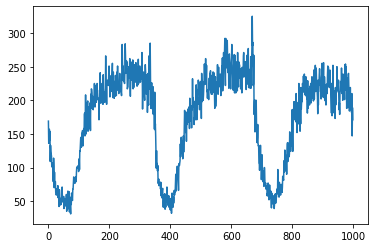

In [134]:
from matplotlib import pyplot as plt
plt.plot(y)
plt.show()

## посчитаем уникальные номера

In [135]:
unique_numbers=df['msisdn'].unique()
len(unique_numbers)

2359

## разобьем весь период времени на интервалы. для каждой границы интервала найдем ближайший сверху момент времени, когда номер регистрировался на вышке. запишем результат в новый датафрейм

In [136]:
quantity_time_intervals=100
min_tstamp=df.tstamp.min(axis=0)
max_tstamp=df.tstamp.max(axis=0)
time_period=(max_tstamp-min_tstamp)//quantity_time_intervals
df_norm=pd.DataFrame(columns=df.columns)

In [137]:
min_tstamp,max_tstamp,time_period

(0, 259198, 2591)

### сначала найдем самый большой tstamp и запишем в словарь координаты этого tstamp

In [15]:
import collections
current_tstamp=collections.defaultdict(tuple)
for number in unique_numbers:
  df1=df.loc[df.msisdn==number]
  idx=df1.tstamp.idxmax()
  current_tstamp[number]=(df.at[idx,'long'],df.at[idx,'lat'])


### теперь пройдем по всем номерам по всем реперным точкам периода и определим наиболее вероятные координаты в этот момент времени. (на моем ноуте примерно 30 минут)

In [138]:
df_norm=pd.DataFrame(columns=df.columns)
for number in unique_numbers:
  for i in range(0,quantity_time_intervals):
    df1=df.loc[(df.msisdn==number)&(df.tstamp<=max_tstamp-i*time_period)&(df.tstamp>max_tstamp-(i+1)*time_period)]
    if df1.size>0:
      idx=df1.tstamp.idxmax()
      df_norm=df_norm.append({'msisdn':int(number),'tstamp':i,'long':df1.at[idx,'long'],'lat':df1.at[idx,'lat']},ignore_index=True)
      current_tstamp[number]=(df1.at[idx,'long'],df1.at[idx,'lat'])
    else:
      df_norm=df_norm.append({'msisdn':int(number),'tstamp':i,'long':current_tstamp[number][0],'lat':current_tstamp[number][1]},ignore_index=True)

### приведем к читаемому виду и проверим, что получилось на примере одного из номеров

In [140]:
df_norm=df_norm.astype({'msisdn':'int64','tstamp':'int64'})
df_norm.loc[df_norm.msisdn==158529599791]


msisdn  tstamp     long      lat
0   158529599791       0  37.9270  55.7736
1   158529599791       1  37.9189  55.7804
2   158529599791       2  37.8618  55.7476
3   158529599791       3  37.8600  55.7518
4   158529599791       4  37.7520  55.7587
..           ...     ...      ...      ...
95  158529599791      95  37.8930  55.7920
96  158529599791      96  37.8930  55.7920
97  158529599791      97  37.9270  55.7736
98  158529599791      98  37.9270  55.7736
99  158529599791      99  37.9270  55.7736

[100 rows x 4 columns]

### создадим тензор всевозможных пар номеров. кол-во строк будет равно len(unique_numbers)*(len(unique_numbers)-1)/2, так как сам с собой номер нам не надо сравнивать. а кол-во столбцов - 2*2*quantity_time_intervals, - 2 долготы и 2 ширины

In [141]:
import torch

In [142]:
x=torch.zeros((int(len(unique_numbers)*(len(unique_numbers)-1)/2),2*2*quantity_time_intervals))

In [143]:
x.shape

torch.Size([2781261, 400])

### на моем ноуте примерно 2-3 часа

In [146]:
idx=0
passed_time=0
for i in unique_numbers:
    print(passed_time/len(unique_numbers),end=' ')
    passed_time+=1
    for j in unique_numbers:
        if i<=j:
          continue
        t1=torch.FloatTensor(df_norm.loc[df_norm.msisdn==i]['long'].values,)
        t2=torch.FloatTensor(df_norm.loc[df_norm.msisdn==i]['lat'].values)
        t3=torch.FloatTensor(df_norm.loc[df_norm.msisdn==j]['long'].values)
        t4=torch.FloatTensor(df_norm.loc[df_norm.msisdn==j]['lat'].values)
        t=torch.cat([t1,t2,t3,t4])
        x[idx]=t
        idx+=1
    
    

0.0 0.000423908435777872 0.000847816871555744 0.001271725307333616 0.001695633743111488 0.00211954217888936 0.002543450614667232 0.002967359050445104 0.003391267486222976 0.0038151759220008477 0.00423908435777872 0.0046629927935565915 0.005086901229334464 0.005510809665112336 0.005934718100890208 0.00635862653666808 0.006782534972445952 0.0072064434082238235 0.007630351844001695 0.008054260279779568 0.00847816871555744 0.008902077151335312 0.009325985587113183 0.009749894022891056 0.010173802458668928 0.0105977108944468 0.011021619330224672 0.011445527766002543 0.011869436201780416 0.012293344637558287 0.01271725307333616 0.01314116150911403 0.013565069944891903 0.013988978380669776 0.014412886816447647 0.01483679525222552 0.01526070368800339 0.015684612123781264 0.016108520559559136 0.016532428995337006 0.01695633743111488 0.01738024586689275 0.017804154302670624 0.018228062738448497 0.018651971174226366 0.01907587961000424 0.01949978804578211 0.019923696481559984 0.020347604917337857

0.17380245866892752 0.17422636710470538 0.17465027554048326 0.17507418397626112 0.175498092412039 0.17592200084781687 0.17634590928359475 0.1767698177193726 0.1771937261551505 0.17761763459092836 0.17804154302670624 0.1784654514624841 0.17888935989826196 0.17931326833403985 0.1797371767698177 0.1801610852055956 0.18058499364137345 0.18100890207715134 0.1814328105129292 0.18185671894870709 0.18228062738448494 0.18270453582026283 0.1831284442560407 0.18355235269181858 0.18397626112759644 0.18440016956337432 0.18482407799915218 0.18524798643493007 0.18567189487070793 0.18609580330648579 0.18651971174226367 0.18694362017804153 0.18736752861381942 0.18779143704959728 0.18821534548537516 0.18863925392115302 0.1890631623569309 0.18948707079270877 0.18991097922848665 0.1903348876642645 0.1907587961000424 0.19118270453582026 0.19160661297159814 0.192030521407376 0.1924544298431539 0.19287833827893175 0.19330224671470964 0.1937261551504875 0.19415006358626535 0.19457397202204324 0.19499788045782

0.35184400169563373 0.3522679101314116 0.3526918185671895 0.35311572700296734 0.3535396354387452 0.3539635438745231 0.354387452310301 0.35481136074607883 0.3552352691818567 0.3556591776176346 0.3560830860534125 0.3565069944891903 0.3569309029249682 0.3573548113607461 0.3577787197965239 0.3582026282323018 0.3586265366680797 0.3590504451038576 0.3594743535396354 0.3598982619754133 0.3603221704111912 0.3607460788469691 0.3611699872827469 0.3615938957185248 0.3620178041543027 0.36244171259008057 0.3628656210258584 0.3632895294616363 0.36371343789741417 0.36413734633319206 0.3645612547689699 0.3649851632047478 0.36540907164052566 0.3658329800763035 0.3662568885120814 0.36668079694785927 0.36710470538363715 0.367528613819415 0.36795252225519287 0.36837643069097076 0.36880033912674864 0.3692242475625265 0.36964815599830436 0.37007206443408225 0.37049597286986014 0.37091988130563797 0.37134378974141585 0.37176769817719374 0.37219160661297157 0.37261551504874946 0.37303942348452734 0.3734633319

KeyboardInterrupt: 

In [23]:
x

tensor([[37.9270, 37.9270, 37.9270,  ..., 55.7525, 55.7525, 55.7525],
        [37.9270, 37.9270, 37.9270,  ..., 55.5803, 55.5803, 55.5803],
        [37.9270, 37.9270, 37.9270,  ..., 55.7661, 55.8134, 55.8134],
        ...,
        [37.6217, 37.6217, 37.6217,  ..., 55.4838, 55.4838, 55.4838],
        [37.6217, 37.6217, 37.6217,  ..., 55.8072, 55.8072, 55.8072],
        [37.6217, 37.6217, 37.6217,  ..., 55.7415, 55.7415, 55.7415]])

In [24]:
x.shape

torch.Size([2785980, 400])

In [25]:
pair=[]
idx=0
for i in unique_numbers:
  # print(i,end=' ')
  for j in unique_numbers:
    if i<=j:
      continue
    pair.append((i,j))
    # idx+=1


In [26]:
pair_back={(pair[i][0],pair[i][1]):i for i in range(len(pair))}

In [27]:
# uploaded = files.upload()

In [28]:
# df=pd.read_csv('C:/Users/User/Megafon/02_Data.csv',sep=';')
df=pd.read_csv('C:/Users/User/Megafon/facts.csv',sep=';')

In [29]:
label=[]
for row in df.iterrows():
  label.append((max(row[1][0],row[1][1]),min(row[1][0],row[1][1])))

In [30]:
true_label=[]
for el in label:
  try:
    num=pair_back[el]
    true_label.append(el)
  except:
    print(el)

(158528852857, 158510912201)
(158530004641, 158528850493)


In [31]:
label=true_label
len(label)

120

In [32]:
numbers_of_labels=[]
for el in label:
  numbers_of_labels.append(pair_back[el])

In [33]:
numbers_of_labels[0:3]

[1527969, 1392489, 1959343]

In [34]:
x_label=x[numbers_of_labels]
x_label.shape

torch.Size([120, 400])

In [90]:
dist=sum(((x[:,i]-x[:,quantity_time_intervals*2+i])**2+(x[:,quantity_time_intervals+i]*x[:,quantity_time_intervals+i]-
       x[:,quantity_time_intervals*3+i]*x[:,quantity_time_intervals*3+i])**2)**0.05 for i in range(quantity_time_intervals))

In [100]:
dist.mean(),dist[numbers_of_labels].mean()

(tensor(133.0491), tensor(85.6052))

In [96]:
dist[numbers_of_labels].argmax()

tensor(34)

In [98]:
numbers_of_labels[34]

2610660

In [99]:
dist[2610660]

tensor(157.6821)

In [35]:
x0=torch.zeros((x.shape[0],1))
for i in range(x0.shape[0]):
  if i in numbers_of_labels:
    x0[i][0]=1

In [36]:
import numpy as np
x_fake=torch.zeros((1200000,x.shape[1]))
for i in range(len(numbers_of_labels)):
  for j in range(10000):
    x_fake[i*10000+j]=x[numbers_of_labels[i]]+torch.tensor(np.random.sample(1)/1000)-0.0005


In [37]:
x[numbers_of_labels[0]][:10]

tensor([37.6490, 37.6490, 37.6490, 37.6490, 37.6490, 37.6490, 37.6490, 37.6490,
        37.6490, 37.6490])

In [38]:
x_fake[0][:10]

tensor([37.6495, 37.6495, 37.6495, 37.6495, 37.6495, 37.6495, 37.6495, 37.6495,
        37.6495, 37.6495])

In [39]:
x1=torch.ones((x_fake.shape[0]),1)
x_fake1=torch.cat((x_fake,x1),dim=1)
x_fake1[:,-1]

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [40]:
no_label=list(set(range(x.shape[0]))-set(numbers_of_labels))

In [41]:
len(no_label)

2785860

In [42]:
numbers_of_labels[0] in no_label

False

In [43]:
x_with_labels=torch.cat((x,x0),dim=1)

In [44]:
x_with_labels[numbers_of_labels[0]][-1]

tensor(1.)

In [45]:
x1=x_with_labels[torch.randperm(x_with_labels.shape[0])]
x2=x1[:int(x_with_labels.shape[0]*0.8)]
x3=x1[int(x_with_labels.shape[0]*0.8):]

In [46]:
sum(x2[:,-1]),sum(x3[:,-1])

(tensor(100.), tensor(20.))

In [47]:
x4=torch.cat((x2,x_fake1),dim=0)
x4.shape

torch.Size([3428784, 401])

In [48]:
X_train=x4[:,:-1]
X_test=x3[:,:-1]
y_train=x4[:,-1]
y_test=x3[:,-1]

In [49]:
sum(y_train)

tensor(1200100.)

In [50]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([3428784, 400]),
 torch.Size([557196, 400]),
 torch.Size([3428784]),
 torch.Size([557196]))

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train.to(device)

tensor([[37.7297, 37.7297, 37.7297,  ..., 54.4803, 54.4803, 54.4803],
        [37.7636, 37.7636, 37.7636,  ..., 55.5912, 55.5912, 55.5912],
        [37.8355, 37.8355, 37.8355,  ..., 55.8096, 55.8096, 55.8096],
        ...,
        [37.5942, 37.5942, 37.5942,  ..., 55.6862, 55.6862, 55.6862],
        [37.5942, 37.5942, 37.5942,  ..., 55.6862, 55.6862, 55.6862],
        [37.5945, 37.5945, 37.5945,  ..., 55.6865, 55.6865, 55.6865]])

In [77]:
class MegafonNet(torch.nn.Module):
  def __init__(self,n_hidden_neurons):
    super(MegafonNet,self).__init__()

    self.fc1=torch.nn.Linear(quantity_time_intervals*4,n_hidden_neurons)
    self.activ1=torch.nn.Sigmoid()
    self.fc2=torch.nn.Linear(n_hidden_neurons,n_hidden_neurons)
    self.activ2=torch.nn.Tanh()
    self.fc3=torch.nn.Linear(n_hidden_neurons,1)
    self.activ3=torch.nn.Sigmoid()
  
  def forward(self,x):
    x=self.fc1(x)
    x=self.activ1(x)
    x=self.fc2(x)
    x=self.activ2(x)
    x=self.fc3(x)
    x=self.activ3(x)
    return x

megafon_net=MegafonNet(200)

In [78]:
loss = torch.nn.BCELoss()

optimizer = torch.optim.Adam(megafon_net.parameters(), 
                             lr=1.0e-3,weight_decay=0.00)

In [79]:
batch_size = 1000

for epoch in range(50000):
    order = torch.randperm(len(X_train))
    total_loss=0
    total_loss_test=0
    iter=0
    iter_test=0
    train_preds=0
    for start_index in range(0, len(X_train), batch_size):
        # print(start_index/len(X_train))
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = megafon_net.forward(x_batch)
        
        loss_value = loss(preds.view(preds.shape[0]), y_batch)
        total_loss+=loss_value
        iter+=1
        loss_value.backward()
        
        optimizer.step()
        
    order = torch.randperm(len(X_test))
    for start_index in range(0,len(X_test),batch_size):
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_test[batch_indexes]
        y_batch = y_test[batch_indexes]
        
        preds = megafon_net.forward(x_batch)
        
        loss_value = loss(preds.view(preds.shape[0]), y_batch)
        total_loss_test+=loss_value
        iter_test+=1
        
    if epoch % 1 == 0:
        print(megafon_net.forward(X_train[:10]))
        print(megafon_net.forward(X_train[-10:]))
#         test_preds = megafon_net.forward(X_test)
        print("train loss=",total_loss/iter)
        print("test loss=",total_loss_test/iter_test)
#         test_preds = test_preds.argmax(dim=1)
#         print(sum(test_preds))
        

RuntimeError: shape '[1000]' is invalid for input of size 784

In [70]:
p=megafon_net.forward(X_train[0:2])
p.view(2).shape

torch.Size([2])

In [76]:
print(megafon_net.forward(X_train[:10]))
print(megafon_net.forward(X_train[-10:]))

tensor([[0.3459],
        [0.3459],
        [0.3459],
        [0.3459],
        [0.3459],
        [0.3459],
        [0.3459],
        [0.3459],
        [0.3459],
        [0.3459]], grad_fn=<SigmoidBackward>)
tensor([[0.3459],
        [0.3459],
        [0.3459],
        [0.3459],
        [0.3459],
        [0.3459],
        [0.3459],
        [0.3459],
        [0.3459],
        [0.3459]], grad_fn=<SigmoidBackward>)


In [123]:
megafon_net.forward(X_train[-1])

tensor([0.8503, 0.2298], grad_fn=<SigmoidBackward>)

In [74]:
loss(preds, y_batch)

tensor(0.8483, grad_fn=<NllLossBackward>)

In [58]:
y_batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 0])

In [1]:
sum(test_preds)

NameError: name 'test_preds' is not defined